**Figure 9: Main Performance**

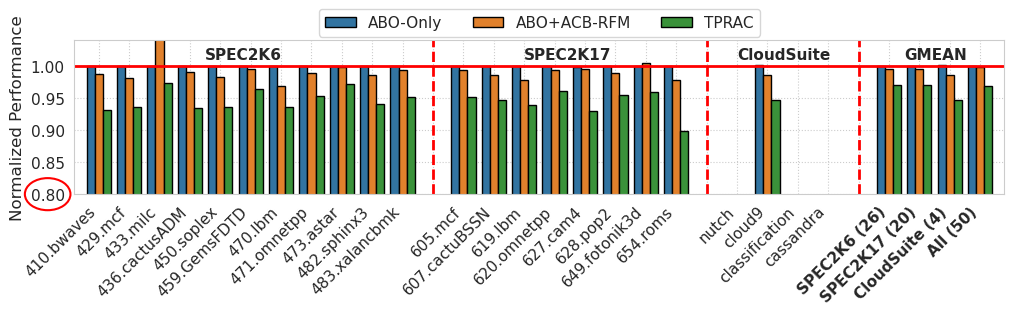

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm
import matplotlib.patches as patches

# Use TrueType fonts for PDF and PS outputs
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts for PDFs
plt.rcParams['ps.fonttype'] = 42  # TrueType fonts for PS files

df_ws_NRH_1024 = pd.read_csv('../results/csvs/results_fig9.csv')
df_ws_NRH_1024 = df_ws_NRH_1024[(df_ws_NRH_1024['NRH'] == 1024) & (df_ws_NRH_1024['Prac Level'] == 1)]

mitigation_interest = ['ABO_Only', 'ABO_RFM', 'TPRAC']

df_melted = pd.melt(
    df_ws_NRH_1024, 
    id_vars=['workload', 'NRH', 'Prac Level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'ABO_Only': 'ABO-Only',
    'ABO_RFM': 'ABO+ACB-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)

# Filter the data for high MPKI workloads
workloads_high_mpki = [
    '410.bwaves', '429.mcf', '433.milc', '436.cactusADM', '450.soplex', '459.GemsFDTD', '470.lbm', '471.omnetpp', '473.astar', '482.sphinx3', '483.xalancbmk', '--', # SPEC2K6: 12
    '605.mcf', '607.cactuBSSN', '619.lbm', '620.omnetpp', '627.cam4', '628.pop2',  '649.fotonik3d', '654.roms', '---', #SPEC2K17: 8
     'nutch', 'cloud9', 'classification', 'cassandra', '-', 
     'SPEC2K6 (26)', 'SPEC2K17 (20)', 'CloudSuite (4)', 'All (50)'
]

# Filter the rows in df_melted that match the specified workloads
df_high_mpki = df_melted[df_melted['workload'].isin(workloads_high_mpki)]

# Set here again if we have changed the name
mitigation_interest = ["ABO-Only", 'ABO+ACB-RFM', 'TPRAC']
df_filtered = df_high_mpki[df_high_mpki['Mitigations'].isin(mitigation_interest)]
df_filtered['Mitigations'] = pd.Categorical(df_filtered['Mitigations'], categories=mitigation_interest, ordered=True)

#### Prepare plotting
# Sort workloads by Benchmark_Types first to ensure the correct order
sns.set_palette('tab10')
sns.set_style("whitegrid")

# Set the global font family
fig, ax = plt.subplots(figsize=(12,2))
plt.rc('font', size=10)

xtick_order = workloads_high_mpki
ax = sns.barplot(x='workload', y='WS',hue='Mitigations', order=xtick_order, data=df_filtered, edgecolor='black')


ax.set_xticks(np.arange(len(xtick_order)))
ax.set_xticklabels([w if w not in ['-', '--', '---'] else '' for w in xtick_order], ha='right', rotation=45, fontsize=11)

# Get the positions of the x-ticks
tick_labels = ax.get_xticklabels()

# Find the positions of geomean labels
geomean_labels = ['CloudSuite (4)', 'SPEC2K6 (26)', 'SPEC2K17 (20)',  'All (50)']
for tick_label in tick_labels:
    if tick_label.get_text() in geomean_labels:
        tick_label.set_fontweight('bold')

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.axvline(11, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.axvline(20, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.axvline(25, 0, 1, color='red', linestyle = '--', linewidth=2)

ax.text(3.5, 1.01, 'SPEC2K6', fontweight='bold', fontsize=11)
ax.text(14, 1.01, 'SPEC2K17', fontweight='bold', fontsize=11)
ax.text(21, 1.01, 'CloudSuite', fontweight='bold', fontsize=11)
ax.text(26.5, 1.01, 'GMEAN', fontweight='bold', fontsize=11)
ax.set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
ax.set_xlabel('')
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5, fancybox=True, shadow=False, fontsize=11)
ax.tick_params(axis='x', which='major', labelsize=11)
ax.tick_params(axis='y', which='major', labelsize=11)

ax.set_ylim(0.8,1.04)
ax.set_xlim(-0.8, 29.8)
# Draw an oval around the starting y-axis (0.8)
ellipse = patches.Ellipse((-1.68, 0.8), width=1.5, height=0.05, edgecolor='red', fill=False, clip_on=False, facecolor='none', linewidth=1.5)
ax.add_patch(ellipse)

plt.grid(True, linestyle=':')
plots_dir = '../results/plots'
os.makedirs(plots_dir, exist_ok=True)
fig.savefig(os.path.join(plots_dir, 'Figure9.pdf'), dpi=600, bbox_inches='tight')


**Figure 10: Sensitivity to PRAC Levels**

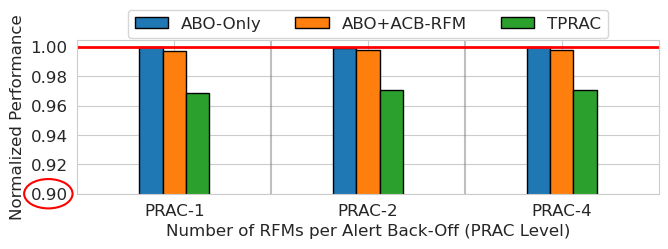

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm
import matplotlib.patches as patches

# Use TrueType fonts for PDF and PS outputs
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts for PDFs
plt.rcParams['ps.fonttype'] = 42  # TrueType fonts for PS files

df_prac_level_study =  pd.read_csv('../results/csvs/results_fig10.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['NRH'] == 1024) & (df_prac_level_study['workload'] == 'All (50)')]

mitigation_interest = ['ABO_Only', 'ABO_RFM', 'TPRAC']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'NRH', 'Prac Level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'ABO_Only': 'ABO-Only',
    'ABO_RFM': 'ABO+ACB-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(7.5, 2))
plt.rc('font', size=12)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.12  # Desired smaller bar width
x_ticks = [1, 2, 4]
num_bars = len(df_melted['Mitigations'].unique())
# Create a mapping for x-tick labels
x_tick_labels = {1: 'PRAC-1', 2: 'PRAC-2', 4: 'PRAC-4'}
# Calculate positions for bars
# x_tick_positions = np.arange(len(x_ticks))  # Positions for x-ticks
x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['Prac Level'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels([x_tick_labels[tick] for tick in x_ticks])  # Use mapped labels
ax.axvline(x=0.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=1.5, color='grey', linestyle='-', alpha=0.5)
ax.set_xlabel('Number of RFMs per Alert Back-Off (PRAC Level)', fontsize=12)
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5, fancybox=True, shadow=False, fontsize=12)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.set_yticks([0.9,0.92,0.94,0.96,0.98,1.0])
ax.set_ylim(0.9,1.005)
ax.set_xlim(-0.5, 2.5)

# Draw an oval around the starting y-axis (0.8)
ellipse = patches.Ellipse((-0.65, 0.9), width=0.25, height=0.02, edgecolor='red', fill=False, clip_on=False, facecolor='none', linewidth=1.5)
ax.add_patch(ellipse)

plots_dir = '../results/plots'
os.makedirs(plots_dir, exist_ok=True)
fig.savefig(os.path.join(plots_dir, 'Figure10.pdf'), dpi=600, bbox_inches='tight')

**Figure 11: Sensitivity to Targeted Refreshes**

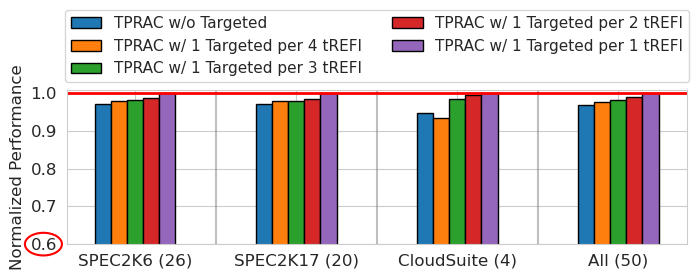

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm
import matplotlib.patches as patches

# Use TrueType fonts for PDF and PS outputs
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts for PDFs
plt.rcParams['ps.fonttype'] = 42  # TrueType fonts for PS files

df_prac_level_study =  pd.read_csv('../results/csvs/results_fig11.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['NRH'].isin([128, 256, 512, 1024, 2048, 4096])) &
                                          (df_prac_level_study['Prac Level'] == 1) &
                                           (df_prac_level_study['workload'].isin(['SPEC2K6 (26)', 'SPEC2K17 (20)', 'CloudSuite (4)', 'All (50)']))]
mitigation_interest = ['TPRAC', 'TPRAC-TREFper4tREFI','TPRAC-TREFper3tREFI','TPRAC-TREFper2tREFI','TPRAC-TREFpertREFI']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'NRH', 'Prac Level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'TPRAC-TREFper4tREFI': 'TPRAC w/ 1 Targeted per 4 tREFI',
    'TPRAC-TREFper3tREFI': 'TPRAC w/ 1 Targeted per 3 tREFI',
    'TPRAC-TREFper2tREFI': 'TPRAC w/ 1 Targeted per 2 tREFI',
    'TPRAC-TREFpertREFI': 'TPRAC w/ 1 Targeted per 1 tREFI',
    'TPRAC': 'TPRAC w/o Targeted'
}

# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 2))
plt.rc('font', size=12)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = df_melted['workload'].unique()
num_bars = len(df_melted['Mitigations'].unique())

x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['workload'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add vertical lines for better visual separation
trh_values = np.sort(df_melted['workload'].unique())
for i in range(len(trh_values) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='-', alpha=0.5)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_ticks)

ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.57), ncol=2, fancybox=True, shadow=False, fontsize=11)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.6,1.008)
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])
# ax.set_xlim(-0.5, 2.5)
# Draw an oval around the starting y-axis (0.8)
ellipse = patches.Ellipse((-0.57, 0.6), width=0.23, height=0.06, edgecolor='red', fill=False, clip_on=False, facecolor='none', linewidth=1.5)
ax.add_patch(ellipse)

plots_dir = '../results/plots'
os.makedirs(plots_dir, exist_ok=True)
fig.savefig(os.path.join(plots_dir, 'Figure11.pdf'), dpi=600, bbox_inches='tight')

**Figure 12: Sensitivity to Rowhammer Threshold**

    workload     NRH  Prac Level                      Mitigations        WS  \
0   All (50)   128.0         1.0                         ABO-Only  0.997262   
1   All (50)   256.0         1.0                         ABO-Only  1.000287   
2   All (50)   512.0         1.0                         ABO-Only  0.999940   
3   All (50)  1024.0         1.0                         ABO-Only  1.000006   
4   All (50)  2048.0         1.0                         ABO-Only  1.000000   
5   All (50)  4096.0         1.0                         ABO-Only  1.000037   
6   All (50)   128.0         1.0                      ABO+ACB-RFM  0.906459   
7   All (50)   256.0         1.0                      ABO+ACB-RFM  0.949827   
8   All (50)   512.0         1.0                      ABO+ACB-RFM  0.985123   
9   All (50)  1024.0         1.0                      ABO+ACB-RFM  0.997605   
10  All (50)  2048.0         1.0                      ABO+ACB-RFM  0.996640   
11  All (50)  4096.0         1.0                    

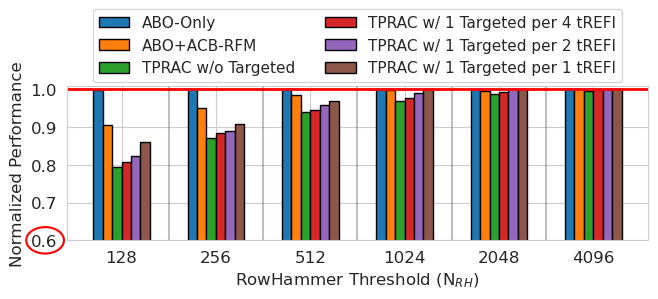

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm
import matplotlib.patches as patches

# Use TrueType fonts for PDF and PS outputs
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts for PDFs
plt.rcParams['ps.fonttype'] = 42  # TrueType fonts for PS files

df_prac_level_study =  pd.read_csv('../results/csvs/results_fig12.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['NRH'].isin([128, 256, 512, 1024, 2048, 4096])) &
                                          (df_prac_level_study['Prac Level'] == 1) &
                                           (df_prac_level_study['workload'] == 'All (50)')]
mitigation_interest = ['ABO_Only', 'ABO_RFM', 'TPRAC', 'TPRAC-TREFper4tREFI','TPRAC-TREFper2tREFI','TPRAC-TREFpertREFI']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'NRH', 'Prac Level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'ABO_Only': 'ABO-Only',
    'ABO_RFM': 'ABO+ACB-RFM',
    'TPRAC-TREFper4tREFI': 'TPRAC w/ 1 Targeted per 4 tREFI',
    'TPRAC-TREFper3tREFI': 'TPRAC w/ 1 Targeted per 3 tREFI',
    'TPRAC-TREFper2tREFI': 'TPRAC w/ 1 Targeted per 2 tREFI',
    'TPRAC-TREFpertREFI': 'TPRAC w/ 1 Targeted per 1 tREFI',
    'TPRAC': 'TPRAC w/o Targeted'
}

# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(7.5, 2))
plt.rc('font', size=12)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [128, 256, 512, 1024, 2048, 4096]
num_bars = len(df_melted['Mitigations'].unique())

x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['NRH'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")


# Add vertical lines for better visual separation
trh_values = np.sort(df_melted['NRH'].unique())
for i in range(len(trh_values) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='-', alpha=0.5)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_ticks)

ax.set_xlabel('RowHammer Threshold (N$_{RH}$)', fontsize=12)
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.55), ncol=2, fancybox=True, shadow=False, fontsize=11)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.6,1.008)
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])
# ax.set_xlim(-0.5, 2.5)
# Draw an oval around the starting y-axis (0.8)
ellipse = patches.Ellipse((-0.81, 0.6), width=0.4, height=0.07, edgecolor='red', fill=False, clip_on=False, facecolor='none', linewidth=1.5)
ax.add_patch(ellipse)

plots_dir = '../results/plots'
os.makedirs(plots_dir, exist_ok=True)
fig.savefig(os.path.join(plots_dir, 'Figure12.pdf'), dpi=600, bbox_inches='tight')